# Document embeddings with Doc2Vec

Just as numerical representations of words can be learned, it is also possible to learn numerical representations of documents. The term document is used here as a general interpretation of various related texts such as sentences, sections, pages or documents. Modern language models aim to learn numerical representations of documents which capture semantic meaning as well as inherent relationships of tokens within the document. While we approach more sophisticated language models at a later stage of this course, we start with two variants which are natural additions to the Word2Vec variants of the last section.

## Doc2Vec

In this [paper](https://arxiv.org/abs/1405.4053), the authors demonstrate how Word2Vec approaches can be adjusted to learn numerical representations of documents. The picture below repeats the CBOW and SG variants of Word2Vec. While CBOW uses surrounding words in the context of a center word to predict the center word, SG aims to predict the surrounding words by the center word. Independent of the variant, words are represented by vectors which can be used to determine word occurrence probabilities. 

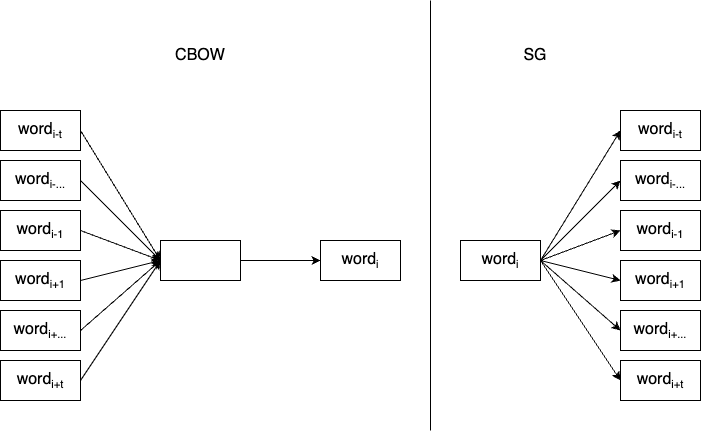

In [1]:
from IPython.display import Image
Image(filename='cbow_sg.png') 

Below we see how the Doc2Vec variants distributed memory of paragraph vectors (PV-DM) and distributed bag of words version of paragraph vectors (PV-DBOW) look like. The PV-DM approach is build in analogy to the CBOW model. It works in the same way, however, a document specific vector is added to the vectors of the surrounding words to predict the center word in a part of the document text. The PV-DBOW is created in analogy to the SG model. Given a document, we use its vector to predict the occurence of a word in the document. 

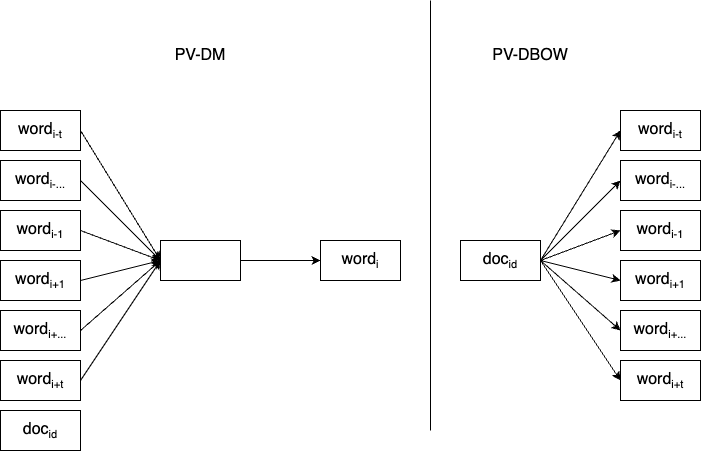

In [2]:
from IPython.display import Image
Image(filename='pv_dm_pv_cbow.png') 

### PV-DM and DV-BOW

Let us go back to our example from the last section. We can proceed as we did before, however, we now have three sentences in the corpus where each is interpreted as a document. This means besides the word ids, we use document ids to convert each word and each document into unique vectors which are initialized randomly in the beginning.

In [3]:
from gensim.utils import simple_preprocess

raw_corpus = [
    "I love vanilla ice cream",
    "I love strawberry ice cream",
    "The main capitol of Germany is Berlin",
    "The main capitol of France is Paris"
]

corpus = [simple_preprocess(doc, min_len = 1) for doc in raw_corpus]

            
word2index = dict()
doc2index = dict()
idx = 0
for i, doc in enumerate(corpus):
    doc2index[" ".join(doc)] = i
    for word in doc:
        if word in word2index.keys():
            continue
        else:
            word2index[word] = idx
            idx += 1


print(word2index)
print(doc2index)

{'i': 0, 'love': 1, 'vanilla': 2, 'ice': 3, 'cream': 4, 'strawberry': 5, 'the': 6, 'main': 7, 'capitol': 8, 'of': 9, 'germany': 10, 'is': 11, 'berlin': 12, 'france': 13, 'paris': 14}
{'i love vanilla ice cream': 0, 'i love strawberry ice cream': 1, 'the main capitol of germany is berlin': 2, 'the main capitol of france is paris': 3}


See below how we randomly generate a word embedding matrix for surrounding words ($W$), one for center words ($V$) and one for document embeddings ($D$).

In [4]:
import torch

# number of words
d = len(word2index)
# number of documents 
docs = len(doc2index)
# dimensions of word and document vectors
p = 4

torch.manual_seed(42)
W = torch.randn(size = (d, p)) 
print(f"Word embeddings for surrounding words:\n {W} \n")
D = torch.randn((docs, p))
print(f"Document embeddings:\n {D} \n")
V = torch.randn((p, d))
print(f"Word embeddings for center words:\n {V} \n")

Word embeddings for surrounding words:
 tensor([[ 1.9269,  1.4873,  0.9007, -2.1055],
        [ 0.6784, -1.2345, -0.0431, -1.6047],
        [-0.7521,  1.6487, -0.3925, -1.4036],
        [-0.7279, -0.5594, -0.7688,  0.7624],
        [ 1.6423, -0.1596, -0.4974,  0.4396],
        [-0.7581,  1.0783,  0.8008,  1.6806],
        [ 1.2791,  1.2964,  0.6105,  1.3347],
        [-0.2316,  0.0418, -0.2516,  0.8599],
        [-1.3847, -0.8712, -0.2234,  1.7174],
        [ 0.3189, -0.4245,  0.3057, -0.7746],
        [-1.5576,  0.9956, -0.8798, -0.6011],
        [ 0.3672,  0.1754,  1.3852, -0.4459],
        [ 1.4451,  0.8564,  2.2181,  0.5232],
        [ 1.1754,  0.5612, -0.4527, -0.7718],
        [-0.1722,  0.5238,  0.0566,  0.4263]]) 

Document embeddings:
 tensor([[ 0.1971, -1.1441,  0.3383,  1.6992],
        [ 0.0109, -0.3387, -1.3407, -0.5854],
        [-0.5644,  1.0563, -1.4692,  1.4332],
        [ 0.7440, -0.4816, -1.0495,  0.6039]]) 

Word embeddings for center words:
 tensor([[ 0.4048, -1.35

Just to provide a deeper understanding, let us go through one example: Let us assume, we use a window size of one word, the center word is *dog* from the first document and the surrounding words are *the* and *would*.

In [5]:
from torch.nn.functional import one_hot

# word vectors for words with index 0 and 2
C_02 = one_hot(torch.tensor([0, 2]), num_classes=d)
word_vectors = torch.matmul(C_02.float(), W)
word_vectors

tensor([[ 1.9269,  1.4873,  0.9007, -2.1055],
        [-0.7521,  1.6487, -0.3925, -1.4036]])

In [6]:
# document vector for the first document
document_vector = torch.matmul(one_hot(torch.tensor([0]), num_classes=docs).float(), D)
document_vector

tensor([[ 0.1971, -1.1441,  0.3383,  1.6992]])

In [7]:
# concatenate these vectors
word_and_document_vectors = torch.concat((word_vectors, document_vector))
word_and_document_vectors

tensor([[ 1.9269,  1.4873,  0.9007, -2.1055],
        [-0.7521,  1.6487, -0.3925, -1.4036],
        [ 0.1971, -1.1441,  0.3383,  1.6992]])

In [8]:
# average these vectors
avg_vector = word_and_document_vectors.mean(dim = 0)
avg_vector

tensor([ 0.4573,  0.6640,  0.2822, -0.6033])

In [9]:
# dot product vectors 
probability_scores = torch.matmul(avg_vector.reshape(-1, p), V)
probability_scores

tensor([[ 0.5822,  0.7698,  0.0092, -0.0079, -0.2323, -0.6753,  0.4420,  0.0856,
          0.9073, -0.4581,  0.2138,  3.7710,  0.5454, -0.4214,  0.8257]])

In [10]:
# transform these values to probabilities with the softmax function
probs = torch.nn.functional.softmax(probability_scores, dim = 1)
probs

tensor([[0.0287, 0.0346, 0.0162, 0.0159, 0.0127, 0.0082, 0.0250, 0.0175, 0.0397,
         0.0101, 0.0199, 0.6966, 0.0277, 0.0105, 0.0366]])

In [11]:
import numpy as  np
# as the actual center word is dog, the corresponding loss value is
-torch.log(probs[0, word2index["love"]])

tensor(3.3627)

This process is done for all examples which can be build over all documents. Each time the model parameters $W, V, D$ are updated to reduce corresponding losses. If we want to generate document embeddings in PV-DBOW fashion, we can omit $W$ and probability predictions would be given by, e.g.:

In [12]:
# again for instance, given document 1
document_vector

tensor([[ 0.1971, -1.1441,  0.3383,  1.6992]])

In [13]:
# probability scores
probability_scores = torch.matmul(document_vector, V)
probability_scores

tensor([[-0.7588, -3.5430,  0.2490,  0.5202, -3.4316,  1.3775,  2.0340,  0.5131,
         -1.2494, -2.1216,  0.1987, -7.5084, -0.1127,  2.7946, -0.3698]])

In [14]:
# and the probability prediction 
probs = torch.nn.functional.softmax(probability_scores, dim = 1)
probs

tensor([[1.2884e-02, 7.9597e-04, 3.5298e-02, 4.6291e-02, 8.8976e-04, 1.0910e-01,
         2.1036e-01, 4.5964e-02, 7.8881e-03, 3.2974e-03, 3.3565e-02, 1.5091e-05,
         2.4584e-02, 4.5006e-01, 1.9011e-02]])

If we want to estimate document vectors only, the word parameters do not need to be updated, they can be kept at their initial values after initialization. In this scenario, word vectors are meaningless, however, document vectors will be similar for documents with similar content and vice versa. See below, how we estimate document vectors for our simple example using the gensim library.

In [15]:
from gensim.models import Doc2Vec
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity


documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(corpus)]
model = Doc2Vec(documents, dm = 0, vector_size=4, window=5, min_count=1, epochs = 500)

doc_vec_sim = pd.DataFrame(cosine_similarity(model.dv.get_normed_vectors()), columns = [f"doc{i+1}" for i in range(len(corpus))], index = [f"doc{i+1}" for i in range(len(corpus))])
doc_vec_sim

,doc1,doc2,doc3,doc4
doc1,1.000000,0.939951,0.791195,0.768707
doc2,0.939951,1.000000,0.708769,0.773758
doc3,0.791195,0.708769,1.000000,0.951385
doc4,0.768707,0.773758,0.951385,1.000000


However, it is also possible to train an update word vectors during training the document vectors. If we set the *dbow_words* argument to $1$, the documentation states that word vectors are trained by SG, while document vectors are trained by PV-DBOW. The positive side effect of this training procedure is that we generate meaningful word embeddings which can also examined w.r.t. to document similarity. Consequently, we can, e.g., examine how similar the meaning of a document is to the meaning of a word. This characteristic can be employed for topic modeling approaches as demonstrated by [this paper](https://arxiv.org/abs/2008.09470). We come back to this in the last subsection of this chapter.

## Using document vectors

Document vectors can be used for different things. Once the Doc2Vec model has been trained, every document can be transformed into numerical representations which can be used for other tasks. For instance, we can train a model which uses the numerical representation to predict the sentiment of the document. Another application is to group documents according to their numerical representation. The result are groups of document which are similar to each other and dissimilar to documents from other groups. If we interpret a group of documents as a topic, we get an idea about different topics in corpora such as financial news, annual company reports, etc. 

### Document vectors for supervised learning tasks

Let us showcase this with a small corpus - the financial phrasebank dataset. Its first five observations can be seen below. The dataset contains 4,217 sentences from news of the Finish stock market. Each sentence has been labeled by multiple annotators as either negative (0), neutral (1) or positive (2). 

In [16]:
from datasets import load_dataset
import pandas as pd

# label 0: negative
# label 1: neutral
# label 2: positive
try:
    fin_pb = pd.read_csv("../yt/financial_phrasebank.csv")
except:
    dataset = load_dataset("financial_phrasebank", "sentences_66agree")
    fin_pb = pd.DataFrame(columns = ["sentence", "label"])
    for i, item in enumerate(dataset["train"]):
        fin_pb.loc[i, :] = [item["sentence"], item["label"]]
    fin_pb.loc[:, "label"] = fin_pb.label.astype(int)
fin_pb.head()

/Users/ralf/Library/Mobile Documents/com~apple~CloudDocs/Kurse/DLTA/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


,sentence,label
0,"According to Gran , the company has no plans t...",1
1,Technopolis plans to develop in stages an area...,1
2,With the new production plant the company woul...,2
3,According to the company 's updated strategy f...,2
4,"For the last quarter of 2010 , Componenta 's n...",2


Once a every sentence is transformed to its document vector, the data set looks as shown below the next cell. 

In [17]:
from gensim.utils import simple_preprocess
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

try:
    doc2vec = Doc2Vec.load("../language_models/financial_phrasebank_d2v_w2v.model")
except:
    class Corpus:
        def __init__(self, documents, preprocessor):
            self.documents = documents
            self.preprocessor = preprocessor
        def __iter__(self):
            for doc_nbr, doc in enumerate(self.documents):
                yield TaggedDocument(simple_preprocess(doc), tags = [doc_nbr])

    corpus = Corpus(fin_pb.sentence.tolist(), simple_preprocess)
    doc2vec = Doc2Vec(corpus, epochs = 100, dm=0, dbow_words=1)

docvecs = doc2vec.dv.get_normed_vectors()
wordvecs = doc2vec.wv.get_normed_vectors()

prediction_df = pd.concat((fin_pb.get(["label"]), pd.DataFrame(docvecs)), axis = 1)
prediction_df = prediction_df.sample(prediction_df.shape[0], random_state=42)

# extract 20% of the data after the model has been trained
hold_out_data = prediction_df.iloc[-int(0.20 * prediction_df.shape[0]):]
# training data is the remaining part of the dataset
training_data = prediction_df.loc[prediction_df.index.difference(hold_out_data.index)]

prediction_df.head()

2024-11-28 10:15:11,247 : INFO : loading Doc2Vec object from ../language_models/financial_phrasebank_d2v_w2v.model
2024-11-28 10:15:11,250 : INFO : loading dv recursively from ../language_models/financial_phrasebank_d2v_w2v.model.dv.* with mmap=None
2024-11-28 10:15:11,250 : INFO : loading wv recursively from ../language_models/financial_phrasebank_d2v_w2v.model.wv.* with mmap=None
2024-11-28 10:15:11,250 : INFO : setting ignored attribute cum_table to None
2024-11-28 10:15:11,255 : INFO : Doc2Vec lifecycle event {'fname': '../language_models/financial_phrasebank_d2v_w2v.model', 'datetime': '2024-11-28T10:15:11.255387', 'gensim': '4.3.3', 'python': '3.11.7 (main, Dec  4 2023, 18:10:11) [Clang 15.0.0 (clang-1500.1.0.2.5)]', 'platform': 'macOS-15.1.1-arm64-arm-64bit', 'event': 'loaded'}


,label,0,1,2,3,4,5,6,7,8,...,90,91,92,93,94,95,96,97,98,99
463,1,-0.078003,0.139442,-0.046493,-0.184602,0.019347,-0.182417,0.128406,0.257314,-0.174664,...,0.059418,-0.027497,0.053010,-0.028947,-0.072151,-0.029470,-0.005255,0.027857,-0.021232,-0.120423
2426,1,-0.135264,0.174769,0.014378,-0.105482,0.140889,-0.054192,-0.042684,0.128843,-0.022797,...,0.144929,-0.006398,0.056056,0.095306,0.126353,0.053509,-0.003943,-0.093263,0.023715,-0.133537
2661,1,-0.015616,0.126934,0.051795,-0.058930,0.070168,-0.071048,0.047179,0.039414,0.104251,...,0.178313,0.000571,-0.156062,-0.044267,0.067836,0.055039,0.191652,0.003744,-0.078656,0.096035
1483,2,-0.115611,-0.025464,0.064858,0.007148,0.007059,-0.165182,0.057989,0.152786,-0.048112,...,-0.072094,0.008463,0.049508,-0.065766,0.077295,-0.013288,0.019827,-0.174426,0.005421,-0.001355
2860,1,-0.060746,0.216108,0.080453,0.032570,0.104492,-0.079791,0.044879,0.016247,-0.290883,...,0.011979,0.003885,-0.051969,0.048972,0.143134,0.019959,0.084879,-0.054980,0.023294,-0.001891


To train a prediction model, one splits the data into two parts. One part is used for training the model, the other part is used to evaluate the model and show if the model also performs well for new and unseen data. The graphic below shows the distribution of labels in the training and hold-out data. The distribution is rather unbalanced as the majority of labeled sentences are neural. 

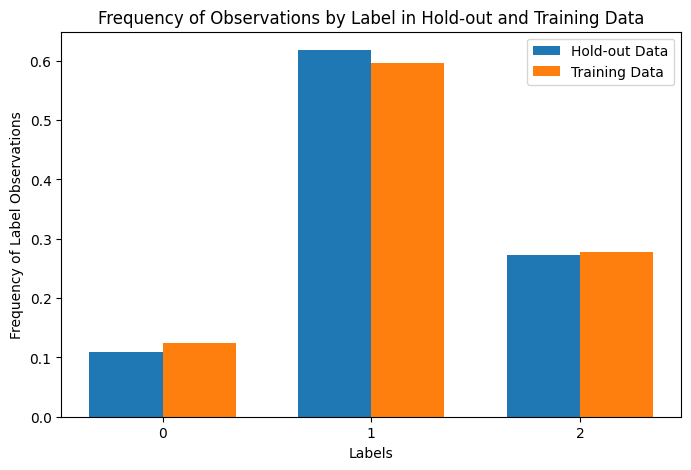

In [18]:
import matplotlib.pylab as plt

hold_out_counts = hold_out_data.groupby("label").size().divide(hold_out_data.shape[0])
training_counts = training_data.groupby("label").size().divide(training_data.shape[0])

labels = sorted(set(hold_out_counts.index).union(set(training_counts.index)))
hold_out_values = [hold_out_counts.get(label, 0) for label in labels]
training_values = [training_counts.get(label, 0) for label in labels]

fig, ax = plt.subplots(figsize=(8, 5))
width = 0.35  # Bar width

x = range(len(labels))

ax.bar(x, hold_out_values, width, label='Hold-out Data')
ax.bar([pos + width for pos in x], training_values, width, label='Training Data')

ax.set_xlabel('Labels')
ax.set_ylabel('Frequency of Label Observations')
ax.set_title('Frequency of Observations by Label in Hold-out and Training Data')
ax.set_xticks([pos + width / 2 for pos in x])
ax.set_xticklabels(labels)
ax.legend()

plt.show()

Given the data set with labels and document vectors, one can choose among a great variety of different machine learning models suited for multi-class prediction. The actual prediction model is not in the center of interest in this chapter. Below, we import a prediction model and evaluate the model by looking the the confusion matrix. A confusion matrix is a tool used in classification tasks to visualize and summarize the performance of a classification model. It is a table that compares the predicted labels from the model with the actual labels of a dataset. Each row of the matrix represents the instances in an actual class, while each column represents the instances in a predicted class (or vice versa).

Thus, all instances on the diagonal are correct predictions of the model, other instances are misclassifications. For instance for the hold out data on the right, 74 instances of positive sentiment predictions (2) are indeed the positive category. However, for 14 instances, a neutral sentence is predicted to be positive and even in 25 instances a negative sentence is predicted to be positive. The actual model performance is not that important for our example. The example is supposed to demonstrate a popular application of the Doc2Vec model 

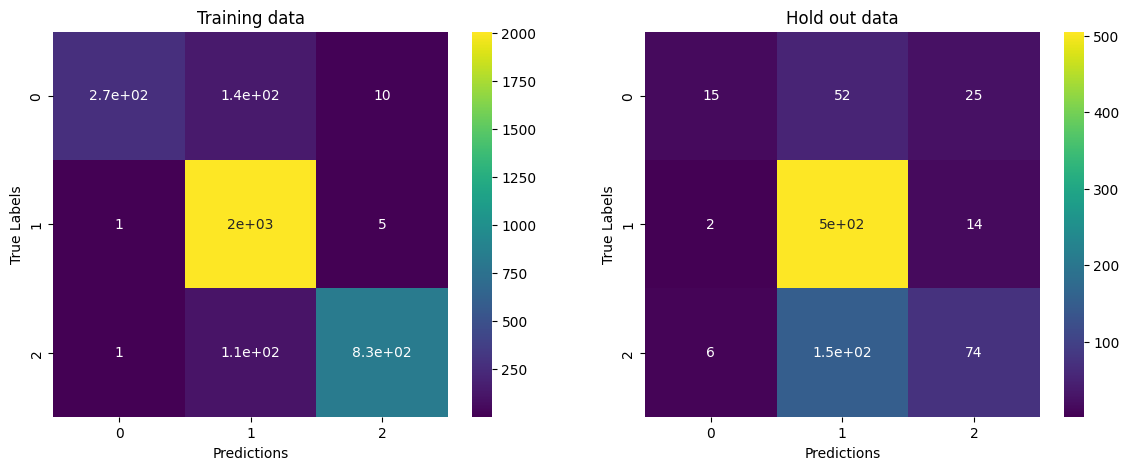

In [19]:
from sklearn.metrics import confusion_matrix
import matplotlib.pylab as plt
import seaborn as sns
import pickle 

with open("../yt/d2v_demo/d2v_finpb_classifier.pkl", "rb") as model_file:
        best_model = pickle.load(model_file)

X_train, X_test = training_data.drop(["label"], axis = 1).values, hold_out_data.drop(["label"], axis = 1).values
y_train, y_test = training_data["label"].values, hold_out_data["label"].values

cm_train = confusion_matrix(y_train, best_model.predict(X_train), labels=best_model.classes_)
cm_test = confusion_matrix(y_test, best_model.predict(X_test), labels=best_model.classes_)

fig, axs = plt.subplots(1, 2, figsize=(14, 5))

sns.heatmap(cm_train, annot = True, cmap='viridis', ax = axs[0])

axs[0].set_xlabel('Predictions')
axs[0].set_ylabel('True Labels')
axs[0].set_title('Training data')

sns.heatmap(cm_test, annot = True, cmap='viridis', ax = axs[1])

axs[1].set_xlabel('Predictions')
axs[1].set_ylabel('True Labels')
axs[1].set_title('Hold out data')

plt.show()

### Gathering corpus information with document vectors in the absence of a target variable

In the absence of a target variable, we still may gather insights in the corpus. One thing we can do is to find documents with similar numerical representations. Usually, this is done by determining cosine similarities between all document pairs in a corpus, and, identify the ones with the highest similarities, given a specific document.  

Take a look at the output of the cell below. The sentence above the line is the document of interest while sentences below the line are the ones for which the vector has the highest cosine similarity to the vector for the document of interest. 

In [20]:
import numpy as np

doc2doc_similarity = docvecs.dot(docvecs.T)
doc2doc_most_similar = np.flip(np.argsort(doc2doc_similarity, axis = 1), axis = 1)[:, 1:]
doc2doc_most_similar_score = np.flip(np.sort(doc2doc_similarity, axis = 1), axis = 1)[:, 1:]

doc_id = 2
print(fin_pb.loc[doc_id].sentence)
print("-"*100)
for id in doc2doc_most_similar[doc_id][:5]:
    print(fin_pb.loc[id].sentence)

With the new production plant the company would increase its capacity to meet the expected increase in demand and would improve the use of raw materials and therefore increase the production profitability .
----------------------------------------------------------------------------------------------------
Lead production , in turn , should increase to 60,000 tonnes through 2009 in what would be a twofold increase from current capacity levels , Zahariev said .
`` Our approach is very much to only use raw materials that are produced in line with the principles of sustainable development .
The soapstone deposits in the Medvezhyegorsk area are expected to increase Tulikivi 's current reserves considerably .
The mill 's raw material need will increase by 100,000 m3 of wood .
We hope to increase traffic volumes with the opening of Freight One Scandinavia . ''


The idea of finding similar documents and grouping them together can be done more systematically by clustering documents according to their vectors. In detail, this approach usually:

* uses a dimensionality reduction to reduce the dimension of document vectors
* uses a clustering algorithm to group documents in the reduced dimension
* averages document vectors for each cluster in their original dimension to calculate topic vectors
* given a Word2Vec model is trained together with the Doc2Vec model, one can further determine words with high cosine similarities to each topic vectors to generate a understanding which keywords describe the topics

While the details of this approach are beyond the scope of this course, the intuition should be clear, once the concept of document and word vectors is understood. Clustering algorithms group observations which are defined by numbers (in our scenario the document vectors) in a way such that members of each cluster have high cosine similarities to each other, but, rather low cosine similarities to members of other clusters. As document vectors have high similarities if the documents content is similar, a group of similar documents is supposed to be related to a topic. For our example below we reduce the UMAP algorithm for reducing the document vector dimension to 10 and groupt these vectors by the HDBSCAN clustering algorithm. The latter assigns the cluster -1 for all members which can not be clearly assigned to a group of documents. For the 4,217 sentences, the algorithm finds 52 groups.

In [21]:
from umap import UMAP
from hdbscan import HDBSCAN

try:
    with open("../yt/d2v_demo/d2v_finpb_10d_reducer.pkl", "rb") as model_file:
        dim_reducer_for_clustering = pickle.load(model_file)
except:
    dim_reducer_for_clustering = UMAP(n_components=10, metric = "cosine")
    dim_reducer_for_clustering.fit(docvecs)
    with open("d2v_demo/d2v_finpb_10d_reducer.pkl", "wb") as file:
        pickle.dump(dim_reducer_for_clustering, file)

X_clustering = dim_reducer_for_clustering.transform(docvecs)

try:
    with open("../yt/d2v_demo/cluster_model.pkl", "rb") as model_file:
        cluster_model = pickle.load(model_file)
except:
    cluster_model = HDBSCAN(min_cluster_size = 10, metric = "euclidean", cluster_selection_method = "eom")
    cluster_model.fit(X_clustering)
    with open("d2v_demo/cluster_model.pkl", "wb") as file:
        pickle.dump(cluster_model, file)

cluster_labels = cluster_model.labels_
unique_labels = np.unique(cluster_labels)

topic_vectors = np.vstack([docvecs[np.where(cluster_labels == label)].mean(axis = 0) for label in unique_labels if not(label == -1)])
topic_vectors = topic_vectors / np.linalg.norm(topic_vectors, axis = 1, keepdims=True)

topic_document_similarities = topic_vectors.dot(docvecs.T)
most_sim_docs_to_topics = np.flip(np.argsort(topic_document_similarities, axis = 1), axis = 1)
most_sim_docs_to_topic_scores = np.flip(np.sort(topic_document_similarities, axis = 1), axis = 1)

print("Cluster labels found by clustering documents.")
unique_labels

Cluster labels found by clustering documents.


array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
       16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32,
       33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49,
       50, 51])

Using the average vectors for each group of documents as a topic vector, we can determine the documents with the highest similarity to this topic vector. Let us review them for one topic below. This is one way to build up a understanding to what the topic is related. 

In [22]:
print("The ten most similar documents to topic number 1.")
print("-"*75)
for idx in most_sim_docs_to_topics[1,:10]:
    print(fin_pb.loc[idx].sentence)

The ten most similar documents to topic number 1.
---------------------------------------------------------------------------
Earnings per share EPS rose to EUR 0.11 from EUR 0.03 .
Earnings per share ( EPS ) amounted to a loss of EUR0 .05 .
Earnings per share ( EPS ) amounted to a loss of EUR0 .38 .
Diluted earnings per share ( EPS ) rose to EUR 1.05 from EUR 0.64 .
Earnings per share EPS in 2005 amounted to a loss of EUR1 .26 .
Earnings per share EPS amounted to EUR0 .03 , up from the loss of EUR0 .08 .
Diluted earnings per share ( EPS ) rose to EUR 3.68 from EUR 0.50 .
Earnings per share EPS amounted to EUR0 .01 .
Earnings per share ( EPS ) amounted to EUR0 .98 , up from the loss of EUR0 .02 .
Diluted earnings per share ( EPS ) rose to EUR 0.52 versus EUR 0.09 .


It is possible to train word and document vectors simultaneously. By this way, the are in the same vector space and the distances between word and document vectors are meaningful. Below, we observe the 20 words which are most similar to the topic from the documents in the cell above. 

In [23]:
topic_word_similarities = topic_vectors.dot(wordvecs.T)
most_sim_words_to_topics = np.flip(np.argsort(topic_word_similarities, axis = 1), axis = 1)
most_sim_words_to_topic_scores = np.flip(np.sort(topic_word_similarities, axis = 1), axis = 1)

for idx in most_sim_words_to_topics[1, :20]:
    print(doc2vec.wv.index_to_key[idx])

diluted
eps
versus
consensus
narrowed
propose
share
eur
earnings
dealers
per
bln
quarterly
outstanding
stood
loss
taxes
compared
corresponding
cents


### Defining topics by keywords and identifying documents

If we omit the clustering, we can define topics by the average vector of keyword vectors. Given such a vector, we can search for documents which are similar to this topic vector. If this behaves as desired, we may get documents with a content the is described by the keywords. A good example in relation to the climate talk identification is shown below.

The cell below imports a Doc2Vec model which is trained using annual 10K form filings from US companies. During the training process, word vectors also have been trained by SG. The first application which comes into mind when working with Doc2Vec is to generate document embeddings. These embeddings can be used for further tasks, e.g., sentiment classification. Besides, document embeddings can be clustered in order to identify topics. Additionally, we can declare a topic of our interest by ourselves with a word list and look for documents which are close to this topic. 

In the cell we also import Apple's 10K filings and split one report into its sentences using the sentence tokenizer from the nltk package. We filter out sentences which are very short or very long and infer the document vector for each sentence. 

In [24]:
import sqlite3
import pandas as pd
from gensim.models.doc2vec import Doc2Vec
from gensim.utils import simple_preprocess
import nltk
import numpy as np
from sklearn.preprocessing import normalize


sent_detector = nltk.data.load('tokenizers/punkt/english.pickle')

# import the Doc2Vec model
d2v = Doc2Vec.load("../language_models/d2v_10K/10K_pvdbow_skipgram_wo_docvecs.pickle")

# load Apple's 10-K filings
conn = sqlite3.connect("../data/dlta_texts.db")
sql_query = "SELECT * FROM filings;"
df_filings = pd.read_sql(sql_query, conn)
apple_filings = df_filings[df_filings.ticker == "AAPL"]
conn.close()

# split the 10K report into sentences
sentences_tmp = sent_detector.tokenize(apple_filings.text[0])
# preprocess the sentences
sentences_tmp = [simple_preprocess(sentence) for sentence in sentences_tmp]
# exclude sentences with word below 15 and above 250
sentences_tmp = [sentence for sentence in sentences_tmp if 15 <= len(sentence) <= 250]

# generate document embeddings for each sentence
doc_vectors = [d2v.infer_vector(sentence) for sentence in sentences_tmp]
# this is optional but I like to normalize the vectors such that they have unit length
doc_vectors = normalize(np.array(doc_vectors), axis = 1)

print("preprocessed sentence:")
print(" ".join(sentences_tmp[0]))
print("This is it embeddings:")
print(doc_vectors[0])

2024-11-28 10:15:20,252 : INFO : loading Doc2Vec object from ../language_models/d2v_10K/10K_pvdbow_skipgram_wo_docvecs.pickle
2024-11-28 10:15:20,595 : INFO : loading dv recursively from ../language_models/d2v_10K/10K_pvdbow_skipgram_wo_docvecs.pickle.dv.* with mmap=None
2024-11-28 10:15:20,596 : INFO : loading wv recursively from ../language_models/d2v_10K/10K_pvdbow_skipgram_wo_docvecs.pickle.wv.* with mmap=None
2024-11-28 10:15:20,596 : INFO : loading vectors from ../language_models/d2v_10K/10K_pvdbow_skipgram_wo_docvecs.pickle.wv.vectors.npy with mmap=None
2024-11-28 10:15:20,634 : INFO : loading syn1 from ../language_models/d2v_10K/10K_pvdbow_skipgram_wo_docvecs.pickle.syn1.npy with mmap=None
2024-11-28 10:15:20,671 : INFO : setting ignored attribute cum_table to None
2024-11-28 10:15:20,671 : INFO : Doc2Vec lifecycle event {'fname': '../language_models/d2v_10K/10K_pvdbow_skipgram_wo_docvecs.pickle', 'datetime': '2024-11-28T10:15:20.671937', 'gensim': '4.3.3', 'python': '3.11.7 (m

preprocessed sentence:
commission file number apple inc exact name of registrant as specified in its charter california state or other jurisdiction of incorporation or organization
This is it embeddings:
[-2.77892966e-02 -1.16526365e-01  9.69111919e-03  4.96698022e-02
 -1.29569918e-01 -2.96495724e-02  3.06717958e-02 -6.43227324e-02
  1.46083506e-02  1.10788547e-01  7.46475980e-02  6.52860925e-02
  4.51842435e-02  4.29546982e-02 -2.99911015e-02 -2.10962840e-03
  6.81449473e-03  1.51063636e-01  2.32735965e-05 -4.89098467e-02
 -6.59670234e-02 -8.30884427e-02 -5.53503297e-02 -3.76370735e-02
 -2.37470772e-02 -7.90155083e-02 -7.30504692e-02  5.97692132e-02
  1.80933287e-03  6.70261309e-02 -2.95417607e-02  1.15519464e-02
 -7.55302161e-02 -5.70085011e-02  2.42516715e-02  7.97616541e-02
  5.38319163e-02 -9.01612937e-02  7.28087872e-02 -6.19134726e-03
  5.63534535e-02 -2.55900547e-02 -1.30481124e-01  7.22862110e-02
 -1.04835406e-01  5.00488887e-03  1.27372190e-01 -9.11690444e-02
  1.41711393e-02

As in the last chapter, we can use a dimensionality reduction technique to visualize documents in the two dimensional vector space. Documents with similar content should be close to each other and vice versa.

In [25]:
import umap
import plotly.express as px
import pickle

try:
    with open("../language_models/d2v_10K/dim_reducer.pkl", "rb") as handle:
        dim_reducer = pickle.load(handle)
except:
    print("Train dimensionality reducer first...")
    dim_reducer = umap.UMAP(n_components=2, metric = "cosine")
    dim_reducer.fit(doc_vectors)
    with open("../language_models/d2v_10K/dim_reducer.pkl", 'wb') as handle:
        pickle.dump(dim_reducer, handle, protocol=pickle.HIGHEST_PROTOCOL)

try:
    doc_vectors_2d = np.load("../language_models/d2v_10K/doc_vectors_2d_demo.npy")
    word_vectors_2d = np.load("../language_models/d2v_10K/word_vectors_2d_demo.npy")
except:
    doc_vectors_2d = dim_reducer.transform(doc_vectors)
    word_vectors_2d = dim_reducer.transform(d2v.wv.get_normed_vectors())


fig = px.scatter(x = doc_vectors_2d[:, 0], y = doc_vectors_2d[:, 1], hover_name = [" ".join(sentence) for sentence in sentences_tmp])
fig.show()

Given word vectors have been trained as well during the Doc2Vec training process the distance between word and document vectors is meaningful. See below the two dimensional representation of sentences and the location of some randomly drawn word vectors. Words in the close surrounding of a document vector should have a similar meaning as the sentence. 

In [26]:
import plotly.express as px

np.random.sample(42)
rnd_doc_idx = np.random.choice(list(range(len(doc_vectors))), 200, replace = False)
doc_df_tmp = pd.DataFrame(doc_vectors_2d, columns = ["u1", "u2"])
doc_df_tmp.loc[:, "label"] = [" ".join(sentences_tmp[idx]) for idx in range(len(sentences_tmp))]
doc_df_tmp.loc[:, "type"] = "document"

word_df_tmp = pd.DataFrame(word_vectors_2d[rnd_doc_idx], columns = ["u1", "u2"])
word_df_tmp.loc[:, "label"] = [d2v.wv.index_to_key[idx] for idx in rnd_doc_idx]
word_df_tmp.loc[:, "type"] = "word"

df_tmp = pd.concat((doc_df_tmp, word_df_tmp))

fig = px.scatter(df_tmp, x = "u1", y = "u2", hover_name = "label", color = "type")
fig.show()

We are going to omit the topic modeling approach as this would also demand knowledge about clustering methods. However, let us continue with a document search (here sentence search) for documents which have a similar meaning to a topic that we define by a word list. Let us assume, we are interested in statements made by Apple in their report w.r.t. to the impact of global warming on their business. First, we look for words which are similar to the average vector of the words *global* and *warming*. Let us take the $20$ most similar words. We build an average vector by averaging all word vectors of these words. 

In [27]:
topic = ["global", "warming"]
topic_similar_words = d2v.wv.most_similar(positive = topic, topn = 20)

topic_words = []
for word in topic_similar_words:
    topic_words.append(word[0])
    print(word)

('climate', 0.7585471272468567)
('greenhouse', 0.678149938583374)
('economy', 0.6498392820358276)
('globally', 0.6493490934371948)
('atmosphere', 0.639726996421814)
('nations', 0.6322587728500366)
('gases', 0.6319488883018494)
('world', 0.6317063570022583)
('carbon', 0.6304970979690552)
('emissions', 0.615446150302887)
('ghgs', 0.6140316724777222)
('ghg', 0.6054237484931946)
('climatic', 0.5981226563453674)
('crisis', 0.5975075364112854)
('continues', 0.596904993057251)
('led', 0.5952749848365784)
('gasses', 0.5952057242393494)
('impacts', 0.5944046974182129)
('decarbonization', 0.5895527601242065)
('increasing', 0.5851758718490601)


In [28]:
# determine the average vector of these word vectors
topic_vector = d2v.wv.get_mean_vector(topic_words)
# normalize the vector (optional, but simplifies the determination of cosine similarities in the next step)
topic_vector = normalize(topic_vector.reshape(1, -1))

As our document and topic vectors already have unit length, cosine similarities can be determined by the dot product of the topic vector and the document vectors. 

In [29]:
# determine topic to document cosine similarities
topic_document_cosine_similarities = np.matmul(topic_vector, doc_vectors.transpose()).flatten()
topic_document_cosine_similarities[:5]

array([ 0.10284807, -0.08850166, -0.01781358,  0.00830959,  0.06075738],
      dtype=float32)

Now we can look for the indices of the documents (in our example sentences) with the highest topic similarities.

In [30]:
most_sim_indices = np.flip(np.argsort(topic_document_cosine_similarities))
most_sim_cosine_scores = np.flip(np.sort(topic_document_cosine_similarities))

for i, idx in enumerate(most_sim_indices[:5]):
    print(f"Topic cosine similarity: {most_sim_cosine_scores[i]:.4f}:\n --------------------------------")
    print(f"Sentence: {' '.join(sentences_tmp[idx])} \n")

Topic cosine similarity: 0.6041:
 --------------------------------
Sentence: many governments regulators investors employees customers and other stakeholders are increasingly focused on environmental social and governance considerations relating to businesses including climate change and greenhouse gas emissions human and civil rights and diversity equity and inclusion 

Topic cosine similarity: 0.5328:
 --------------------------------
Sentence: the company cannot guarantee that it will achieve its announced environmental social and governance goals and initiatives 

Topic cosine similarity: 0.5327:
 --------------------------------
Sentence: covid has had and continues to have significant impact around the world prompting governments and businesses to take unprecedented measures in response 

Topic cosine similarity: 0.4705:
 --------------------------------
Sentence: public safety measures can also adversely impact consumer demand for the company products and services in affected ar

## Outlook

Alright, equipped with Word2Vec and Doc2Vec we are able to generate embeddings of words and documents which capture similarities in the meaning. However, these models are not able to understand context. For instance, given the two sentences "Peter buys a lot of junk food and eats it all", "Peter buys salad to start a healthy life", the word "buy" is going to be treated in the same way by a Doc2Vec model. However given the context of junk food or salad, the first sentence rather has a negative sentiment while the second sentence has positive sentiment. Modern language models use mechanism which capture contextual information. In the next chapter we take a look at the transformer model which includes an attention mechanism that allows the model to learn the meaning of context. 